In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%%capture
!pip install contextily
!pip install pysal

#1.Import libraries and read dataset files

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import re
import contextily as ctx
import libpysal as ps
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from shapely.geometry import Polygon, Point
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from shapely import wkt


In [ ]:
os.chdir('/content/drive/MyDrive/SSCI575-final project/')


In [ ]:
ny_squirrels = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20231017.csv')
ny_squirrels.head()

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894)


Read in the table containing the location boundaries, and the conditions of the grids.

In [ ]:
df_grids = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Hectare_Grid_20231103.csv')
df_grids

,the_geom,id,xmin,xmax,ymin,ymax
0,MULTIPOLYGON (((-73.95816284567162 40.80102139...,82,"989,030.73113","989,358.81512","231,243.27134","231,571.35533"
1,MULTIPOLYGON (((-73.95712568765475 40.80058581...,83,"989,358.81512","989,686.89911","231,243.27134","231,571.35533"
2,MULTIPOLYGON (((-73.95608854321127 40.80015023...,84,"989,686.89911","990,014.9831","231,243.27134","231,571.35533"
3,MULTIPOLYGON (((-73.9550514123412 40.799714636...,85,"990,014.9831","990,343.06709","231,243.27134","231,571.35533"
4,MULTIPOLYGON (((-73.9540142950446 40.799279030...,86,"990,343.06709","990,671.15108","231,243.27134","231,571.35533"
...,...,...,...,...,...,...
373,MULTIPOLYGON (((-73.97750517097374 40.76696330...,865,"990,343.06709","990,671.15108","217,791.82775","218,119.91174"
374,MULTIPOLYGON (((-73.97646841686014 40.76652789...,866,"990,671.15108","990,999.23507","217,791.82775","218,119.91174"
375,MULTIPOLYGON (((-73.97543167630229 40.76609247...,867,"990,999.23507","991,327.31906","217,791.82775","218,119.91174"
376,MULTIPOLYGON (((-73.97439494930025 40.76565705...,868,"991,327.31906","991,655.40305","217,791.82775","218,119.91174"


In [ ]:
df_grids_info = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Hectare_Data_20231017.csv')
df_grids_info

,Hectare,Shift,Date,Anonymized Sighter,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting
0,01A,AM,10072018,1.100000e+02,"70º F, Foggy",Some,NaN,"Humans, Pigeons",Busy,NaN,1,4,22.0
1,01A,PM,10142018,1.770000e+02,"54º F, overcast",Abundant,NaN,"Humans, Pigeons",Busy,NaN,1,7,26.0
2,01B,AM,10122018,1.100000e+01,"60º F, sunny",Some,NaN,"Humans, Dogs, Pigeons, Horses",Busy,NaN,1,17,23.0
3,01B,PM,10192018,1.090000e+02,"59.8º F, Sun, Cool",Some,NaN,"Humans, Dogs, Pigeons, Sparrow, Blue jay",Busy,NaN,1,10,35.0
4,01C,PM,10132018,2.410000e+02,"55° F, Partly Cloudy",None,NaN,"Humans, Dogs, Pigeons, Birds",Busy,NaN,1,10,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,09A,AM,10132018,1.791802e+08,NaN,Some,NaN,"Humans, Dogs, Pigeons, Rats, Blue jays",Busy,NaN,3,12,20.0
696,11F,PM,10062018,1.680000e+02,NaN,Some,NaN,"Humans, Dogs, Pigeons",Busy,NaN,3,3,26.0
697,12G,PM,10072018,1.061071e+02,80º F,None,NaN,"Humans, Cat bird",Busy,NaN,3,7,29.0
698,12H,PM,10072018,1.061071e+02,79º F,None,NaN,"Humans, Sparrows",Busy,NaN,3,8,30.0


#2.Feature Engineering

Extract the weather condition descriptions and make them into categorical variables.

In [ ]:
def simplify_weather(weather):
    if pd.isna(weather):
        return 'Unknown'
    elif 'sun' in weather.lower() or 'clear' in weather.lower() or 'perfect' in weather.lower():
        return 'Sunny'
    elif 'cloudy' in weather.lower() or 'overcast' in weather.lower() or 'mist' in weather.lower() or 'fog' in weather.lower():
        return 'Cloudy/Overcast'
    elif 'rain' in weather.lower() or 'drizzle' in weather.lower() or 'drizz' in weather.lower() or 'rain' in weather.lower() or 'sprink' in weather.lower(): # drizz for drizzle and drizzling
        return 'Rainy'
    else:
        return 'Other'

df_grids_info['weather'] = df_grids_info['Sighter Observed Weather Data'].apply(simplify_weather)
df_grids_info

,Hectare,Shift,Date,Anonymized Sighter,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting,weather
0,01A,AM,10072018,1.100000e+02,"70º F, Foggy",Some,NaN,"Humans, Pigeons",Busy,NaN,1,4,22.0,Cloudy/Overcast
1,01A,PM,10142018,1.770000e+02,"54º F, overcast",Abundant,NaN,"Humans, Pigeons",Busy,NaN,1,7,26.0,Cloudy/Overcast
2,01B,AM,10122018,1.100000e+01,"60º F, sunny",Some,NaN,"Humans, Dogs, Pigeons, Horses",Busy,NaN,1,17,23.0,Sunny
3,01B,PM,10192018,1.090000e+02,"59.8º F, Sun, Cool",Some,NaN,"Humans, Dogs, Pigeons, Sparrow, Blue jay",Busy,NaN,1,10,35.0,Sunny
4,01C,PM,10132018,2.410000e+02,"55° F, Partly Cloudy",None,NaN,"Humans, Dogs, Pigeons, Birds",Busy,NaN,1,10,25.0,Cloudy/Overcast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,09A,AM,10132018,1.791802e+08,NaN,Some,NaN,"Humans, Dogs, Pigeons, Rats, Blue jays",Busy,NaN,3,12,20.0,Unknown
696,11F,PM,10062018,1.680000e+02,NaN,Some,NaN,"Humans, Dogs, Pigeons",Busy,NaN,3,3,26.0,Unknown
697,12G,PM,10072018,1.061071e+02,80º F,None,NaN,"Humans, Cat bird",Busy,NaN,3,7,29.0,Other
698,12H,PM,10072018,1.061071e+02,79º F,None,NaN,"Humans, Sparrows",Busy,NaN,3,8,30.0,Other


Now, deal with the temperature data, this can be a little hard since the temperature has some missing values, and what is even harder is that many of them are in the form of plain text such as 'mid 40s', and some other ones are even in celcius unit, instead of farenheit.   
So this part focuses on turning those plain text data into numerical data processable by a machine.

In [ ]:
import re
import numpy as np

np.random.seed(30)

def convert_temperature(temperature):
    # 是否有missing value
    if pd.isna(temperature):
        return np.nan
    # 处理字符串，因为温度只可能在字符串第一部分
    temperature_str = temperature.split(',')[0].lower()
    # 判断是否包含数字
    if not re.search(r'\d+', temperature):
        return np.nan
    # if celcius exists, convert it to farenheit
    if 'º C' in temperature_str:
        celsius_temp = float(re.search(r'\d+\.\d+|\d+', temperature_str).group())
        fahrenheit_temp = celsius_temp * 9/5 + 32
        return round(fahrenheit_temp, 2)

    # deal with '40s':
    # if 'low 40s': make it 40 + rand(0, 5)
    # if 'mid 40s': make it 45(40+5)
    # if 'high 40s': make it 40+rand(5, 10)
    elif 's' in temperature_str:
        base_temp = float(re.search(r'\d+', temperature_str).group())
        if 'low' in temperature_str:
            return round(base_temp + np.random.uniform(0, 5), 2)
        elif 'mid' in temperature_str:
            return round(base_temp + 5, 2)
        else:
            return round(base_temp + np.random.uniform(0, 10), 2)

    # for average temperature if in the form of '40-45'
    elif '-' in temperature_str:
        temp_range = re.findall(r'\d+\.\d+|\d+', temperature_str)
        temp_avg = np.mean([float(temp) for temp in temp_range])
        return round(temp_avg, 2)

    else:
        # no precess needed, but will have to extract the numerical values inside
        return float(re.search(r'\d+\.?\d*', temperature).group())

df_grids_info['Temperature'] = df_grids_info['Sighter Observed Weather Data'].apply(convert_temperature)

df_grids_info

,Hectare,Shift,Date,Anonymized Sighter,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting,weather,Temperature
0,01A,AM,10072018,1.100000e+02,"70º F, Foggy",Some,NaN,"Humans, Pigeons",Busy,NaN,1,4,22.0,Cloudy/Overcast,70.0
1,01A,PM,10142018,1.770000e+02,"54º F, overcast",Abundant,NaN,"Humans, Pigeons",Busy,NaN,1,7,26.0,Cloudy/Overcast,54.0
2,01B,AM,10122018,1.100000e+01,"60º F, sunny",Some,NaN,"Humans, Dogs, Pigeons, Horses",Busy,NaN,1,17,23.0,Sunny,60.0
3,01B,PM,10192018,1.090000e+02,"59.8º F, Sun, Cool",Some,NaN,"Humans, Dogs, Pigeons, Sparrow, Blue jay",Busy,NaN,1,10,35.0,Sunny,59.8
4,01C,PM,10132018,2.410000e+02,"55° F, Partly Cloudy",None,NaN,"Humans, Dogs, Pigeons, Birds",Busy,NaN,1,10,25.0,Cloudy/Overcast,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,09A,AM,10132018,1.791802e+08,NaN,Some,NaN,"Humans, Dogs, Pigeons, Rats, Blue jays",Busy,NaN,3,12,20.0,Unknown,NaN
696,11F,PM,10062018,1.680000e+02,NaN,Some,NaN,"Humans, Dogs, Pigeons",Busy,NaN,3,3,26.0,Unknown,NaN
697,12G,PM,10072018,1.061071e+02,80º F,None,NaN,"Humans, Cat bird",Busy,NaN,3,7,29.0,Other,80.0
698,12H,PM,10072018,1.061071e+02,79º F,None,NaN,"Humans, Sparrows",Busy,NaN,3,8,30.0,Other,79.0


Import census grids to plot the temperature on the map.

In [ ]:
try:
  df_grids['the_geom'] = df_grids['the_geom'].apply(wkt.loads)
except:
  pass
census_grids = gpd.GeoDataFrame(df_grids, geometry = 'the_geom')
census_grids.crs = 'EPSG:4326'

First, use ny_squirrels data to give df_grids_info their coordinates to get the full geospatial information for each observation. Spatial join the observation to the grids.

In [ ]:
df_grids_obsv = ny_squirrels.merge(df_grids_info, on = ['Hectare', 'Shift', 'Date'], how = 'left')
df_grids_obsv = gpd.GeoDataFrame(df_grids_obsv, geometry = [Point(x, y) for x, y in zip(df_grids_obsv.X, df_grids_obsv.Y)])
df_grids_obsv

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting,weather,Temperature,geometry
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,NaN,Humans,Busy,NaN,1.0,3.0,24.0,Cloudy/Overcast,59.00,POINT (-73.95613 40.79408)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,NaN,"Humans, Dogs, Pigeons, Birds",Calm,NaN,2.0,7.0,25.0,Sunny,45.00,POINT (-73.96886 40.78378)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,NaN,"Humans, Dogs, Horses",Busy,NaN,1.0,8.0,18.0,Cloudy/Overcast,NaN,POINT (-73.97428 40.77553)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,NaN,"Humans, Dogs",Busy,NaN,1.0,16.0,25.0,Cloudy/Overcast,61.00,POINT (-73.95964 40.79031)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,NaN,"Humans, Birds (non-pigeon)",Calm,NaN,1.0,13.0,50.0,Sunny,52.00,POINT (-73.97027 40.77621)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,-73.963943,40.790868,30B-AM-1007-04,30B,AM,10072018,4,Adult,Gray,NaN,...,NaN,"Humans, Dogs, Assorted Birds",Busy,NaN,1.0,12.0,20.0,Cloudy/Overcast,70.00,POINT (-73.96394 40.79087)
3019,-73.970402,40.782560,19A-PM-1013-05,19A,PM,10132018,5,Adult,Gray,White,...,1 reusable bag,"Humans, Dogs, Sparrows, Blue Finch-like Birds,...",Busy,NaN,1.0,6.0,26.0,Sunny,51.73,POINT (-73.97040 40.78256)
3020,-73.966587,40.783678,22D-PM-1012-07,22D,PM,10122018,7,Adult,Gray,"Black, Cinnamon, White",...,NaN,"Humans, Pigeons, Sparrows","Calm, Busy",NaN,1.0,7.0,26.0,Sunny,61.00,POINT (-73.96659 40.78368)
3021,-73.963994,40.789915,29B-PM-1010-02,29B,PM,10102018,2,NaN,Gray,"Cinnamon, White",...,NaN,"Humans, Dogs, Birds",Busy,NaN,1.0,5.0,25.0,Sunny,75.44,POINT (-73.96399 40.78992)


In [ ]:
df_space_time = census_grids.sjoin(df_grids_obsv, op = 'contains')
df_space_time

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:2177: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


,the_geom,id,xmin,xmax,ymin,ymax,index_right,X,Y,Unique Squirrel ID,...,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting,weather,Temperature
0,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...",82,"989,030.73113","989,358.81512","231,243.27134","231,571.35533",846,-73.958264,40.800046,42A-AM-1019-01,...,Some,NaN,"Humans, Dogs, Pigeons, Rat, Chipmunk",Calm,NaN,1.0,1.0,30.0,Sunny,45.0
1,"MULTIPOLYGON (((-73.95713 40.80059, -73.95609 ...",83,"989,358.81512","989,686.89911","231,243.27134","231,571.35533",470,-73.957013,40.799603,42B-AM-1014-02,...,None,NaN,"Humans, Dogs",Calm,NaN,2.0,2.0,NaN,Unknown,NaN
1,"MULTIPOLYGON (((-73.95713 40.80059, -73.95609 ...",83,"989,358.81512","989,686.89911","231,243.27134","231,571.35533",1432,-73.957408,40.800119,42B-AM-1014-01,...,None,NaN,"Humans, Dogs",Calm,NaN,2.0,2.0,NaN,Unknown,NaN
2,"MULTIPOLYGON (((-73.95609 40.80015, -73.95505 ...",84,"989,686.89911","990,014.9831","231,243.27134","231,571.35533",614,-73.955694,40.799093,42C-AM-1007-04,...,NaN,NaN,"Humans, Dogs",Busy,NaN,1.0,4.0,27.0,Other,71.0
2,"MULTIPOLYGON (((-73.95609 40.80015, -73.95505 ...",84,"989,686.89911","990,014.9831","231,243.27134","231,571.35533",1574,-73.956184,40.799204,42C-PM-1013-05,...,Some,NaN,"Humans, Dogs, Chipmunk",Busy,NaN,1.0,6.0,26.0,Cloudy/Overcast,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,"MULTIPOLYGON (((-73.97439 40.76566, -73.97336 ...",868,"991,327.31906","991,655.40305","217,791.82775","218,119.91174",1625,-73.973687,40.764911,1I-PM-1012-02,...,Some,NaN,"Humans, Hawks, Dogs, Pigeons, Cats",Busy,NaN,2.0,4.0,70.0,Sunny,NaN
376,"MULTIPOLYGON (((-73.97439 40.76566, -73.97336 ...",868,"991,327.31906","991,655.40305","217,791.82775","218,119.91174",351,-73.974001,40.765008,1H-PM-1013-01,...,None,NaN,Humans,Busy,NaN,1.0,2.0,28.0,Cloudy/Overcast,56.0
376,"MULTIPOLYGON (((-73.97439 40.76566, -73.97336 ...",868,"991,327.31906","991,655.40305","217,791.82775","218,119.91174",949,-73.973654,40.765144,1H-AM-1012-02,...,Some,NaN,"Humans, Pigeons, Small birds",Busy,NaN,1.0,2.0,27.0,Sunny,59.0
376,"MULTIPOLYGON (((-73.97439 40.76566, -73.97336 ...",868,"991,327.31906","991,655.40305","217,791.82775","218,119.91174",338,-73.974496,40.765259,1H-AM-1012-01,...,Some,NaN,"Humans, Pigeons, Small birds",Busy,NaN,1.0,2.0,27.0,Sunny,59.0


In [ ]:
# extract the temperature distribution for mapping
temp_temp = df_space_time.groupby('the_geom')[['Temperature']].mean().reset_index()
temp_temp = gpd.GeoDataFrame(temp_temp, geometry = 'the_geom')

Also, this dataset contains information about the animals, but also in the form of plain text, so we also need to transfer this into dummy variables.

In [ ]:
def create_animal_variables(df):
    df['Dog'] = 0 # 0 means not appearing, 1 means appearing
    df['Bird'] = 0
    df_temp = df.copy() # to avoid changing the original dataframe
    df_temp['Other Animal Sightings'].fillna('', inplace=True)
    # fill the missing values with an empty string
    for index, row in df_temp.iterrows():
        if row['Other Animal Sightings'] == '':
            continue
        else:
            animals = row['Other Animal Sightings']
            birds = ['pigeons', 'bird', 'robin', 'sparrow', 'woodpecker', 'jay']
            if 'dog' in animals.lower():
                df.at[index, 'Dog'] = 1
            for bird in birds:
                if bird in animals.lower():
                    df.at[index, 'Bird'] = 1

create_animal_variables(df_space_time)

df_space_time

,the_geom,id,xmin,xmax,ymin,ymax,index_right,X,Y,Unique Squirrel ID,...,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting,weather,Temperature,Dog,Bird
0,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...",82,"989,030.73113","989,358.81512","231,243.27134","231,571.35533",846,-73.958264,40.800046,42A-AM-1019-01,...,"Humans, Dogs, Pigeons, Rat, Chipmunk",Calm,NaN,1.0,1.0,30.0,Sunny,45.0,1,1
1,"MULTIPOLYGON (((-73.95713 40.80059, -73.95609 ...",83,"989,358.81512","989,686.89911","231,243.27134","231,571.35533",470,-73.957013,40.799603,42B-AM-1014-02,...,"Humans, Dogs",Calm,NaN,2.0,2.0,NaN,Unknown,NaN,1,0
1,"MULTIPOLYGON (((-73.95713 40.80059, -73.95609 ...",83,"989,358.81512","989,686.89911","231,243.27134","231,571.35533",1432,-73.957408,40.800119,42B-AM-1014-01,...,"Humans, Dogs",Calm,NaN,2.0,2.0,NaN,Unknown,NaN,1,0
2,"MULTIPOLYGON (((-73.95609 40.80015, -73.95505 ...",84,"989,686.89911","990,014.9831","231,243.27134","231,571.35533",614,-73.955694,40.799093,42C-AM-1007-04,...,"Humans, Dogs",Busy,NaN,1.0,4.0,27.0,Other,71.0,1,0
2,"MULTIPOLYGON (((-73.95609 40.80015, -73.95505 ...",84,"989,686.89911","990,014.9831","231,243.27134","231,571.35533",1574,-73.956184,40.799204,42C-PM-1013-05,...,"Humans, Dogs, Chipmunk",Busy,NaN,1.0,6.0,26.0,Cloudy/Overcast,55.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,"MULTIPOLYGON (((-73.97439 40.76566, -73.97336 ...",868,"991,327.31906","991,655.40305","217,791.82775","218,119.91174",1625,-73.973687,40.764911,1I-PM-1012-02,...,"Humans, Hawks, Dogs, Pigeons, Cats",Busy,NaN,2.0,4.0,70.0,Sunny,NaN,1,1
376,"MULTIPOLYGON (((-73.97439 40.76566, -73.97336 ...",868,"991,327.31906","991,655.40305","217,791.82775","218,119.91174",351,-73.974001,40.765008,1H-PM-1013-01,...,Humans,Busy,NaN,1.0,2.0,28.0,Cloudy/Overcast,56.0,1,1
376,"MULTIPOLYGON (((-73.97439 40.76566, -73.97336 ...",868,"991,327.31906","991,655.40305","217,791.82775","218,119.91174",949,-73.973654,40.765144,1H-AM-1012-02,...,"Humans, Pigeons, Small birds",Busy,NaN,1.0,2.0,27.0,Sunny,59.0,1,1
376,"MULTIPOLYGON (((-73.97439 40.76566, -73.97336 ...",868,"991,327.31906","991,655.40305","217,791.82775","218,119.91174",338,-73.974496,40.765259,1H-AM-1012-01,...,"Humans, Pigeons, Small birds",Busy,NaN,1.0,2.0,27.0,Sunny,59.0,1,1


Then, add the observations of suirrels to the map.

<ipython-input-23-0f007a72582f>:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


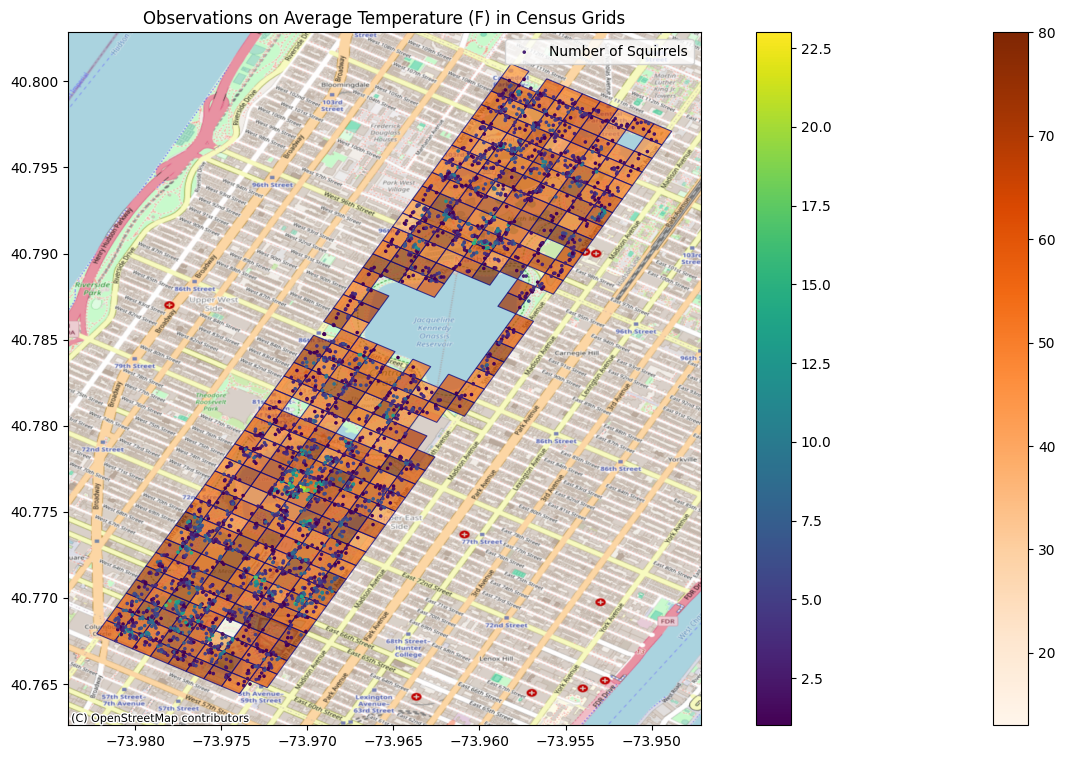

In [ ]:
fig3, ax3 = plt.subplots(figsize = (18, 9))
temp_temp.plot(ax = ax3, column = 'Temperature', linewidth = .8, cmap = 'Oranges',
               edgecolor = 'navy', alpha = .7, legend = True, label = 'Average Temperature (F)')
df_grids_obsv.plot(ax = ax3, column = 'Hectare Squirrel Number',
                   legend = True, markersize = 2.5, label = 'Number of Squirrels')
ctx.add_basemap(ax3, crs = census_grids.crs, source = ctx.providers.OpenStreetMap.Mapnik)

'''legend1 = ax3.legend(title = 'Average Temperature (F)', loc = 'center left')
legend2 = ax3.legend(title = 'Number of Squirrels', loc = 'center right')
ax3.add_artist(legend1)
ax3.add_artist(legend2)'''
plt.legend()
plt.title('Observations on Average Temperature (F) in Census Grids')
plt.show()

Construct the dataset for modeling using the format of space-time cube. There is a row for each day and every census grid. Assign the grids their geometry and transfer the table to a geodataframe.
stmodel = spatial temporal model

In [ ]:
df_space_time['date'] = df_space_time['Date'].astype(str).apply(lambda d: d[-4:] + '/' + d[:2] + '/' + d[2:-4]) +\
                       df_space_time['Shift'].apply(lambda s: ' 11:59:59' if s == 'AM' else ' 23:59:59')

In [ ]:
st_cube = [[id_, date] for id_ in df_grids['id'] for date in df_space_time['date'].unique()]
df_stmodel = pd.DataFrame(data = st_cube, columns = ['id', 'date'])
df_stmodel

,id,date
0,82,2018/10/19 11:59:59
1,82,2018/10/14 11:59:59
2,82,2018/10/07 11:59:59
3,82,2018/10/13 23:59:59
4,82,2018/10/12 23:59:59
...,...,...
8311,869,2018/10/12 11:59:59
8312,869,2018/10/20 11:59:59
8313,869,2018/10/08 23:59:59
8314,869,2018/10/10 23:59:59


In [ ]:
try:
    df_stmodel['xmin']
except:
    df_stmodel = df_stmodel.merge(df_grids, how = 'left')

try:
    df_stmodel.geometry
except:
    df_stmodel = gpd.GeoDataFrame(df_stmodel, geometry = 'the_geom')
    df_stmodel.crs = 'EPSG:4326'
df_stmodel

,id,date,the_geom,xmin,xmax,ymin,ymax
0,82,2018/10/19 11:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533"
1,82,2018/10/14 11:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533"
2,82,2018/10/07 11:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533"
3,82,2018/10/13 23:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533"
4,82,2018/10/12 23:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533"
...,...,...,...,...,...,...,...
8311,869,2018/10/12 11:59:59,"MULTIPOLYGON (((-73.97336 40.76522, -73.97232 ...","991,655.40305","991,983.48704","217,791.82775","218,119.91174"
8312,869,2018/10/20 11:59:59,"MULTIPOLYGON (((-73.97336 40.76522, -73.97232 ...","991,655.40305","991,983.48704","217,791.82775","218,119.91174"
8313,869,2018/10/08 23:59:59,"MULTIPOLYGON (((-73.97336 40.76522, -73.97232 ...","991,655.40305","991,983.48704","217,791.82775","218,119.91174"
8314,869,2018/10/10 23:59:59,"MULTIPOLYGON (((-73.97336 40.76522, -73.97232 ...","991,655.40305","991,983.48704","217,791.82775","218,119.91174"


Next, fill the dataframe by finding required variables.

First, assign each grid the number of squirrels found in each time interval. If there are multiple observations, use the mean of the numbers; if there is no record for a grid in a time interval, use the global mean temperature of that time interval.

<Axes: >

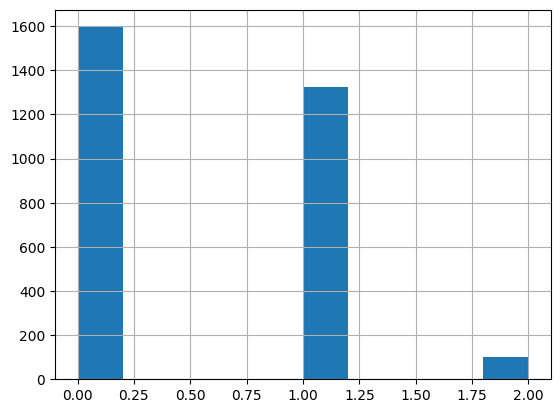

In [ ]:
df_space_time['Litter Amount'] = df_space_time['Litter'].apply(lambda a: 2 if a == 'Abundant' else (1 if a == 'Some' else 0))
df_space_time['Litter Amount'].hist()

Explore more features, for instance, the appearance of other animals.

In [ ]:
def create_animal_variables(df):
    df['Dog'] = 0 # 0 means not appearing, 1 means appearing
    df['Bird'] = 0
    df_temp = df.copy() # to avoid changing the original dataframe
    df_temp['Other Animal Sightings'].fillna('', inplace=True)
    # fill the missing values with an empty string
    for index, row in df_temp.iterrows():
        if row['Other Animal Sightings'] == '':
            continue
        else:
            animals = row['Other Animal Sightings']
            birds = ['pigeons', 'bird', 'robin', 'sparrow', 'woodpecker', 'jay']
            if 'dog' in animals.lower():
                df.at[index, 'Dog'] = 1
            for bird in birds:
                if bird in animals.lower():
                    df.at[index, 'Bird'] = 1

create_animal_variables(df_grids_info)

In [ ]:
try:
    df_space_time['Dog']
except:
    df_space_time = df_space_time.merge(df_grids_info[['Hectare', 'Shift', 'Date', 'Dog', 'Bird']], on = ['Hectare', 'Shift', 'Date'], how = 'left')

Building up features for our `design_table` variable.

In [ ]:
list_count = [] # 松鼠数量
list_F = [] # 列表变量，存储华氏度
list_lit = []
list_dog = []
list_bird = []
for idx, st in enumerate(st_cube):
    if sum((df_space_time['date'] == st[1]) & (df_space_time['id'] == st[0])) == 0: # 如果相应的id和date同时都没有出现，就意味着这个时间内这个grid内没有观测到松鼠
        list_count.append(0) # list添加0，因为没有观测到松鼠
        list_F.append(df_space_time[df_space_time['date'] == st[1]]['Temperature'].mean()) # 填充当日的全局平均值
        list_lit.append(0) # 填充0
        list_dog.append(0) # 填充0
        list_bird.append(0)
        continue
    # 已经排除没有看到松鼠的情况，可以给list_count列表插入值
    list_count.append(df_space_time[(df_space_time['date'] == st[1]) & (df_space_time['id'] == st[0])]['Hectare Squirrel Number'].mean())

    if sum(df_space_time[(df_space_time['date'] == st[1]) & (df_space_time['id'] == st[0])]['Temperature'].notnull()) > 0: # 有观测记录，但是温度为空
        list_F.append(df_space_time[(df_space_time['date'] == st[1]) & (df_space_time['id'] == st[0])]['Temperature'].mean())
        list_lit.append(df_space_time[(df_space_time['date'] == st[1]) & (df_space_time['id'] == st[0])]['Litter Amount'].mean())
        list_dog.append(df_space_time[(df_space_time['date'] == st[1]) & (df_space_time['id'] == st[0])]['Dog'].max())
        list_bird.append(df_space_time[(df_space_time['date'] == st[1]) & (df_space_time['id'] == st[0])]['Bird'].max())

    else: # 有观测记录，且温度值没有缺失
        list_F.append(df_space_time[df_space_time['date'] == st[1]]['Temperature'].mean())
        list_lit.append(df_space_time[df_space_time['date'] == st[1]]['Litter Amount'].mean())
        list_dog.append(df_space_time[df_space_time['date'] == st[1]]['Dog'].max())
        list_bird.append(df_space_time[df_space_time['date'] == st[1]]['Bird'].max())



df_stmodel['Count'] = list_count
df_stmodel['Temperature'] = list_F
df_stmodel['Litter Amount'] = list_lit
df_stmodel['Dog'] = list_lit
df_stmodel['Bird'] = list_bird

Create some dummy variables from weather
* Other
* Sunny
* Cloudy/Overcast
* Rainy

In [ ]:
df_stmodel['Other'] = 0
df_stmodel['Sunny'] = 0
df_stmodel['Cloudy'] = 0
df_stmodel['Rainy'] = 0

for index, row in df_grids_info.iterrows():
    if row['weather'] == 'Sunny':
        df_stmodel.at[index, 'Sunny'] = 1
    elif row['weather'] == 'Cloudy/Overcast':
        df_stmodel.at[index, 'Cloudy'] = 1
    elif row['weather'] == 'Rainy':
        df_stmodel.at[index, 'Rainy'] = 1
    elif row['weather'] == 'Other':
        df_stmodel.at[index, 'Other'] = 1

df_stmodel.head()

,id,date,the_geom,xmin,xmax,ymin,ymax,Count,Temperature,Litter Amount,Dog,Bird,Other,Sunny,Cloudy,Rainy
0,82,2018/10/19 11:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",1.0,45.000000,1.0,1.0,1,0,0,1,0
1,82,2018/10/14 11:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",0.0,50.715263,0.0,0.0,0,0,0,1,0
2,82,2018/10/07 11:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",0.0,70.005076,0.0,0.0,0,0,1,0,0
3,82,2018/10/13 23:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",0.0,53.790447,0.0,0.0,0,0,1,0,0
4,82,2018/10/12 23:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",0.0,60.541667,0.0,0.0,0,0,0,1,0


In [ ]:
df_grids_info['weather'].value_counts()

Cloudy/Overcast    323
Sunny              231
Other               74
Rainy               53
Unknown             19
Name: weather, dtype: int64

Also, there is a column which givs a brief description on whether the area is crowded by visitors. Like the workflow above, we try to build some dummy variables.

In [ ]:
df_grids_info[df_grids_info['Date'] == 10072018]['Hectare Conditions'].value_counts()

Busy          60
Calm          29
Moderate       5
Calm, Busy     1
Name: Hectare Conditions, dtype: int64

In [ ]:
df_grids_info[df_grids_info['Date'] == 10072018]['Hectare Conditions'].value_counts().index[0]

'Busy'

This function is to tackle the missing values of describing the conditions:   
Given its date, fill in the value according to the most-appeared condition.

In [ ]:
def fill_missing_condition(date):
    # get all count values
    value_count = df_grids_info[df_grids_info['Date'] == 10072018]['Hectare Conditions'].value_counts()
    # select the 1st index, which is the index correspond to the condition that appeared the most
    return value_count.index[0]

Firstly, set all cells with `Calm, Busy` or `moderate` values to `medium` , then fill the empty values

In [ ]:
for index, row in df_grids_info.iterrows():
    if type(row['Hectare Conditions']) == float:
        continue
    if row['Hectare Conditions'] == 'Medium' or row['Hectare Conditions'] == 'Calm, Busy':
        df_grids_info.at[index, 'Hectare Conditions'] = 'Moderate'

for index, row in df_grids_info.iterrows():
    if type(row['Hectare Conditions']) == float:
        date = df_grids_info.at[index, 'Date']
        df_grids_info.at[index, 'Hectare Conditions'] = fill_missing_condition(date)

df_grids_info['Hectare Conditions'].head()

0    Busy
1    Busy
2    Busy
3    Busy
4    Busy
Name: Hectare Conditions, dtype: object

In [ ]:
df_grids_info['Busy'] = 0
df_grids_info['Calm'] = 0
df_grids_info['Moderate'] = 0

for index, row in df_grids_info.iterrows():
    if row['Hectare Conditions'] == 'Busy':
        df_grids_info.at[index, 'Busy'] = 1
    elif row['Hectare Conditions'] == 'Calm':
        df_grids_info.at[index, 'Calm'] = 1
    elif row['Hectare Conditions'] == 'Moderate':
        df_grids_info.at[index, 'Moderate'] = 1

df_grids_info.head()

,Hectare,Shift,Date,Anonymized Sighter,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting,weather,Temperature,Dog,Bird,Busy,Calm,Moderate
0,01A,AM,10072018,110.0,"70º F, Foggy",Some,NaN,"Humans, Pigeons",Busy,NaN,1,4,22.0,Cloudy/Overcast,70.0,0,1,1,0,0
1,01A,PM,10142018,177.0,"54º F, overcast",Abundant,NaN,"Humans, Pigeons",Busy,NaN,1,7,26.0,Cloudy/Overcast,54.0,0,1,1,0,0
2,01B,AM,10122018,11.0,"60º F, sunny",Some,NaN,"Humans, Dogs, Pigeons, Horses",Busy,NaN,1,17,23.0,Sunny,60.0,1,1,1,0,0
3,01B,PM,10192018,109.0,"59.8º F, Sun, Cool",Some,NaN,"Humans, Dogs, Pigeons, Sparrow, Blue jay",Busy,NaN,1,10,35.0,Sunny,59.8,1,1,1,0,0
4,01C,PM,10132018,241.0,"55° F, Partly Cloudy",None,NaN,"Humans, Dogs, Pigeons, Birds",Busy,NaN,1,10,25.0,Cloudy/Overcast,55.0,1,1,1,0,0


The `Temperature` column has some empty values, fill in them with the average temperature.

In [ ]:
df_grids_info[(df_grids_info['Date'] == 10142018) & (df_grids_info['Shift'] == 'AM')]['Litter'].value_counts()

None        20
Some        18
Abundant     2
Name: Litter, dtype: int64

In [ ]:
for index, row in df_grids_info.iterrows():
    if pd.isna(df_grids_info.at[index, 'Litter']):
        date = row['Date']
        shift = row['Shift']
        df_grids_info.at[index, 'Temperature'] = mean_temp.loc[(date,  shift), 'Temperature']

Similarly, tackle the `Litter` column

In [ ]:
for index, row in df_grids_info.iterrows():
    if pd.isna(df_grids_info.at[index, 'Litter']):
        date = row['Date']
        shift = row['Shift']
        most_appeared_condition = df_grids_info[(df_grids_info['Date'] == date) & (df_grids_info['Shift'] == shift)]['Litter'].value_counts().index[0]
        df_grids_info.at[index, 'Litter'] = most_appeared_condition

df_grids_info.head()

,Hectare,Shift,Date,Anonymized Sighter,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,Number of sighters,Number of Squirrels,Total Time of Sighting,weather,Temperature,Dog,Bird,Busy,Calm,Moderate
0,01A,AM,10072018,110.0,"70º F, Foggy",Some,NaN,"Humans, Pigeons",Busy,NaN,1,4,22.0,Cloudy/Overcast,70.0,0,1,1,0,0
1,01A,PM,10142018,177.0,"54º F, overcast",Abundant,NaN,"Humans, Pigeons",Busy,NaN,1,7,26.0,Cloudy/Overcast,54.0,0,1,1,0,0
2,01B,AM,10122018,11.0,"60º F, sunny",Some,NaN,"Humans, Dogs, Pigeons, Horses",Busy,NaN,1,17,23.0,Sunny,60.0,1,1,1,0,0
3,01B,PM,10192018,109.0,"59.8º F, Sun, Cool",Some,NaN,"Humans, Dogs, Pigeons, Sparrow, Blue jay",Busy,NaN,1,10,35.0,Sunny,59.8,1,1,1,0,0
4,01C,PM,10132018,241.0,"55° F, Partly Cloudy",None,NaN,"Humans, Dogs, Pigeons, Birds",Busy,NaN,1,10,25.0,Cloudy/Overcast,55.0,1,1,1,0,0


Now, map the Litter condition as below:
* None - 0
* Some - 1
* Abundant - 2

In [ ]:
def remap_litter_condition(litter):
    if(litter == 'Some'):
        return 1
    elif(litter == 'Abundant'):
        return 2
    elif(litter == 'None'):
        return 0

df_grids_info['mapped_litter'] = df_grids_info['Litter'].apply(remap_litter_condition)
df_grids_info.head()

,Hectare,Shift,Date,Anonymized Sighter,Sighter Observed Weather Data,Litter,Litter Notes,Other Animal Sightings,Hectare Conditions,Hectare Conditions Notes,...,Number of Squirrels,Total Time of Sighting,weather,Temperature,Dog,Bird,Busy,Calm,Moderate,mapped_litter
0,01A,AM,10072018,110.0,"70º F, Foggy",Some,NaN,"Humans, Pigeons",Busy,NaN,...,4,22.0,Cloudy/Overcast,70.0,0,1,1,0,0,1
1,01A,PM,10142018,177.0,"54º F, overcast",Abundant,NaN,"Humans, Pigeons",Busy,NaN,...,7,26.0,Cloudy/Overcast,54.0,0,1,1,0,0,2
2,01B,AM,10122018,11.0,"60º F, sunny",Some,NaN,"Humans, Dogs, Pigeons, Horses",Busy,NaN,...,17,23.0,Sunny,60.0,1,1,1,0,0,1
3,01B,PM,10192018,109.0,"59.8º F, Sun, Cool",Some,NaN,"Humans, Dogs, Pigeons, Sparrow, Blue jay",Busy,NaN,...,10,35.0,Sunny,59.8,1,1,1,0,0,1
4,01C,PM,10132018,241.0,"55° F, Partly Cloudy",None,NaN,"Humans, Dogs, Pigeons, Birds",Busy,NaN,...,10,25.0,Cloudy/Overcast,55.0,1,1,1,0,0,0


In [ ]:
df_grids_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Hectare                        700 non-null    object 
 1   Shift                          700 non-null    object 
 2   Date                           700 non-null    int64  
 3   Anonymized Sighter             700 non-null    float64
 4   Sighter Observed Weather Data  681 non-null    object 
 5   Litter                         700 non-null    object 
 6   Litter Notes                   6 non-null      object 
 7   Other Animal Sightings         668 non-null    object 
 8   Hectare Conditions             700 non-null    object 
 9   Hectare Conditions Notes       74 non-null     object 
 10  Number of sighters             700 non-null    int64  
 11  Number of Squirrels            700 non-null    int64  
 12  Total Time of Sighting         680 non-null    flo

similarly, create dummy variables in our `df_stmodel` dataframe.

In [ ]:
df_stmodel['Busy'] = 0
df_stmodel['Calm'] = 0
df_stmodel['Moderate'] = 0

for index, row in df_grids_info.iterrows():
    if row['Hectare Conditions'] == 'Busy':
        df_stmodel.at[index, 'Busy'] = 1
    elif row['Hectare Conditions'] == 'Calm':
        df_stmodel.at[index, 'Calm'] = 1
    elif row['Hectare Conditions'] == 'Moderate':
        df_stmodel.at[index, 'Moderate'] = 1

df_stmodel.head()

,id,date,the_geom,xmin,xmax,ymin,ymax,Count,Temperature,Litter Amount,Dog,Bird,Other,Sunny,Cloudy,Rainy,Busy,Calm,Moderate
0,82,2018/10/19 11:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",1.0,45.000000,1.0,1.0,1,0,0,1,0,1,0,0
1,82,2018/10/14 11:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",0.0,50.715263,0.0,0.0,0,0,0,1,0,1,0,0
2,82,2018/10/07 11:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",0.0,70.005076,0.0,0.0,0,0,1,0,0,1,0,0
3,82,2018/10/13 23:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",0.0,53.790447,0.0,0.0,0,0,1,0,0,1,0,0
4,82,2018/10/12 23:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",0.0,60.541667,0.0,0.0,0,0,0,1,0,1,0,0


In [ ]:
df_stmodel.head()

,id,date,the_geom,xmin,xmax,ymin,ymax,Count,Temperature,Litter Amount,Dog,Bird,Other,Sunny,Cloudy,Rainy,Busy,Calm,Moderate
0,82,2018/10/19 11:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",1.0,45.000000,1.0,1.0,1,0,0,1,0,1,0,0
1,82,2018/10/14 11:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",0.0,50.715263,0.0,0.0,0,0,0,1,0,1,0,0
2,82,2018/10/07 11:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",0.0,70.005076,0.0,0.0,0,0,1,0,0,1,0,0
3,82,2018/10/13 23:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",0.0,53.790447,0.0,0.0,0,0,1,0,0,1,0,0
4,82,2018/10/12 23:59:59,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ...","989,030.73113","989,358.81512","231,243.27134","231,571.35533",0.0,60.541667,0.0,0.0,0,0,0,1,0,1,0,0


In [ ]:
df_stmodel.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 8316 entries, 0 to 8315
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             8316 non-null   int64   
 1   date           8316 non-null   object  
 2   the_geom       8316 non-null   geometry
 3   xmin           8316 non-null   object  
 4   xmax           8316 non-null   object  
 5   ymin           8316 non-null   object  
 6   ymax           8316 non-null   object  
 7   Count          8316 non-null   float64 
 8   Temperature    8316 non-null   float64 
 9   Litter Amount  8316 non-null   float64 
 10  Dog            8316 non-null   float64 
 11  Bird           8316 non-null   int64   
 12  Other          8316 non-null   int64   
 13  Sunny          8316 non-null   int64   
 14  Cloudy         8316 non-null   int64   
 15  Rainy          8316 non-null   int64   
 16  Busy           8316 non-null   int64   
 17  Calm           8316 non-n

Calculate the first order temporal lag term of squirrel counts for each observation, except those on the first day.

In [ ]:
df_stmodel.sort_values(['id', 'date'], inplace = True)
df_stmodel['count_t0'] = df_stmodel.groupby('id')['Count'].diff() # 松鼠观察值的一阶滞后项

The Spatial Weighted Poisson Regression will be performed by pysal. Calculate the distance based saptial weights matrix using the Rook Contiguty (as the rectangular tracts are evenly assigned), and then create spatial lag terms.

In [ ]:
try:
    df_stmodel['Dog']
except:
    df_stmodel = df_stmodel.merge(df_space_time[['id', 'date', 'Dog', 'Bird']], on = [], how = 'left')

In [ ]:
df_space_time[['id', 'date']].nunique()

id      336
date     22
dtype: int64

In [ ]:
df_space_time.loc[df_space_time['Dog'].isnull(), 'Dog'] = 0
df_space_time.loc[df_space_time['Bird'].isnull(), 'Bird'] = 0

In [ ]:
coordinates = df_stmodel.centroid.apply(lambda g: [g.x, g.y]).to_numpy() # 计算出所有grid的中心点坐标
coordinates

<ipython-input-56-ea7614b4cbf0>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coordinates = df_stmodel.centroid.apply(lambda g: [g.x, g.y]).to_numpy() # 计算出所有grid的中心点坐标


array([list([-73.95793086120493, 40.80040953461998]),
       list([-73.95793086120493, 40.80040953461998]),
       list([-73.95793086120493, 40.80040953461998]), ...,
       list([-73.97312623648911, 40.76460978707024]),
       list([-73.97312623648911, 40.76460978707024]),
       list([-73.97312623648911, 40.76460978707024])], dtype=object)

In [ ]:
%%capture
design_table = df_stmodel[df_stmodel['count_t0'].notnull()].copy().reset_index(drop = True) # 该table去掉第一个时段的观测数据（count_t0不为空，第一天对应该值应为null）
w_rook = ps.weights.Rook.from_dataframe(design_table) # pysal的Rook函数，邻接矩阵，为0和1组成，0表示不相邻，1则表示相邻

In [ ]:
# 在 PySAL（Python Spatial Analysis Library）中，ps.weights.lag_spatial 函数用于计算空间拉格朗日乘子（spatial lag）。

# 空间拉格朗日乘子是一种用于考察空间自相关的统计量。在空间统计分析中，空间自相关表示一个地理空间中的观测值是否在空间上彼此相关。空间拉格朗日乘子是一个常用的度量方式，它涉及到一个变量的观测值与其相邻观测值之间的加权平均。

# ps.weights.lag_spatial 函数的输入通常是一个权重矩阵（例如，Rook 或 Queen 权重矩阵）和一个变量的值数组。该函数将计算每个观测值的空间拉格朗日乘子，表示该观测值与其相邻观测值之间的加权平均。这可以通过以下步骤完成：

# 对于每个观测值，计算其相邻观测值的加权平均，权重由权重矩阵定义。
# 将这些加权平均值作为空间拉格朗日乘子的值，形成一个新的数组。
# 这个过程可以帮助分析空间单位之间的关联性，以及观测值之间是否存在空间自相关。

Add the day-night shift to the table, where AM is 1 and PM is 0.

In [ ]:
design_table['Shift'] = pd.to_datetime(design_table['date']).apply(lambda d: 0 if d.hour == 23 else 1)
design_table['Count'] = round(design_table['Count'])

In [ ]:
design_table.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7938 entries, 0 to 7937
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             7938 non-null   int64   
 1   date           7938 non-null   object  
 2   the_geom       7938 non-null   geometry
 3   xmin           7938 non-null   object  
 4   xmax           7938 non-null   object  
 5   ymin           7938 non-null   object  
 6   ymax           7938 non-null   object  
 7   Count          7938 non-null   float64 
 8   Temperature    7938 non-null   float64 
 9   Litter Amount  7938 non-null   float64 
 10  Dog            7938 non-null   float64 
 11  Bird           7938 non-null   int64   
 12  Other          7938 non-null   int64   
 13  Sunny          7938 non-null   int64   
 14  Cloudy         7938 non-null   int64   
 15  Rainy          7938 non-null   int64   
 16  Busy           7938 non-null   int64   
 17  Calm           7938 non-n

In [ ]:
design_table['intercept'] = 1 # 引入常数项表示截距
X1 = design_table[['Temperature', 'count_t0', 'Shift', 'intercept']]
y = design_table['Count']

# Fit the Poisson regression model with spatial weights
model_1 = sm.GLM(y, X1, family = sm.families.Poisson())
results_1 = model_1.fit()

# Print regression results
print(results_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                 7938
Model:                            GLM   Df Residuals:                     7934
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4112.3
Date:                Sat, 02 Dec 2023   Deviance:                       5927.7
Time:                        01:22:12   Pearson chi2:                 1.07e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5854
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature     0.0104      0.002      4.606      

In [ ]:
def BPJB_test(res, X):
    residuals = res.resid_deviance  # Get the residuals
    bp_test = het_breuschpagan(residuals, X)
    bp_statistic = bp_test[0]
    bp_p_value = bp_test[1]
    print("BP Test Statistic:", bp_statistic)
    print("BP Test P-value:", bp_p_value)

    jb_statistic, jb_p_value, skewness, kurtosis = jarque_bera(residuals)
    print("Jarque-Bera Statistic:", jb_statistic)
    print("Jarque-Bera P-value:", jb_p_value)

In [ ]:
BPJB_test(results_1, X1)

BP Test Statistic: 810.500034323759
BP Test P-value: 2.2856260792527297e-175
Jarque-Bera Statistic: 165928.77180027906
Jarque-Bera P-value: 0.0


Given a significance level of 0.05, all the independent variables have significant correlations with the number of squirrels. However, the comparatively low Pseudo R-squared indicates potential overfitting.

Plot the correlation map between all the input variables.

In [ ]:
# 考虑部分地区0数值较多，在这些区域内，局部温度无法对松鼠个数进行解释，即与松鼠个数不相关，因为在部分区域（可能因为区域的其他非温度因素），无论温度如何变化，松鼠的个数都不会变化
design_table['if F'] = design_table[['Temperature', 'count_t0']].apply(lambda r: r[0] if r[1] > 0 else 0, axis = 1)
design_table[['if F']].describe()

,if F
count,7938.000000
mean,5.717660
std,18.113647
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,83.810000


In [ ]:
design_table[['Count', 'Temperature', 'count_t0', 'if F']].corr()

,Count,Temperature,count_t0,if F
Count,1.000000,0.055344,0.700469,0.809924
Temperature,0.055344,1.000000,0.029942,0.102438
count_t0,0.700469,0.029942,1.000000,0.608470
if F,0.809924,0.102438,0.608470,1.000000


Split the dataset into training and test datasets.

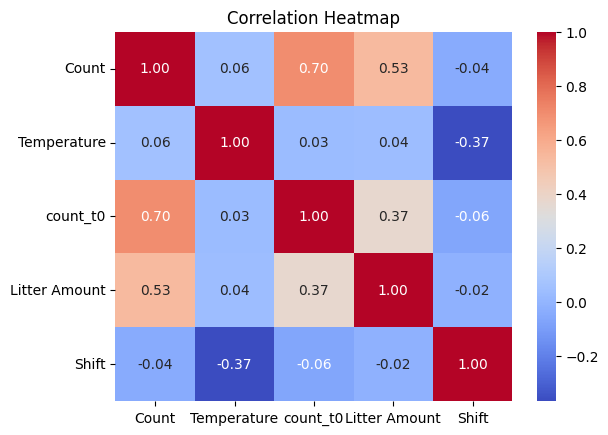

In [ ]:
sns.heatmap(design_table[['Count', 'Temperature', 'count_t0',
                          'Litter Amount', 'Shift']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

The mere temperature is globally correlated with the total number of squirrels. However, when it comes to specific grids, the temperature is not necessarily correlated with squirrels. Thus, create a new field of temperature, 'if F' to consider the number of squirrels in the last time interval.

In [ ]:
X2 = sm.add_constant(design_table[['count_t0', 'if F']])
y = design_table['Count']

# Fit the Poisson regression model with spatial weights
model_2 = sm.GLM(y, X2, family = sm.families.Poisson())
results_2 = model_2.fit()

# 调用 summary() 函数查看模型摘要信息
model_summary = results_2.summary()
print(model_summary)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                 7938
Model:                            GLM   Df Residuals:                     7935
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2251.9
Date:                Sat, 02 Dec 2023   Deviance:                       2207.0
Time:                        01:22:53   Pearson chi2:                 1.31e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.7405
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1442      0.054    -57.863      0.0

It is between now, with an improved Pseudo R-squared and significant independent variables. Then, cperform Koenker-Bassett (BP) and Jarque-Bera tests for heteroscedasticity and normality of residuals.

In [ ]:
BPJB_test(results_2, X2)

BP Test Statistic: 169.63647978393305
BP Test P-value: 1.4585000561340499e-37
Jarque-Bera Statistic: 1201119.3763095737
Jarque-Bera P-value: 0.0


Obviously, some variances within the response variable, the count of squirrels, have not been exposed yet. Consider changing the way of constructing the spatial weights matrix.

## Feature Engineering for Spatial Terms

Note that we use a set of space-time cubes, we should construct a spatial weight matrix for data at one time point and copy it to the other time points.

Also, try several types of spatial weight matrices to construct the spatial lag terms: Queen Contiguity weights, K-nearest neighbor weights (KNN), and Gaussian Kernel weights.

In [ ]:
design_table = design_table.sort_values(['date', 'id']).reset_index()
del design_table['index']
tab_for_swmatrix = design_table[design_table['date'] == design_table['date'].unique()[0]]

In [ ]:
%%capture
# Queen Contiguity weights
w_queen = ps.weights.Queen.from_dataframe(tab_for_swmatrix)
'''
# Gaussian Kernel weights
w_gaussian = ps.weights.Kernel.from_dataframe(tab_for_swmatrix, function = 'gaussian', bandwidth = 0.1)'''

# K-nearest neighbor weights (KNN)
w_knn = ps.weights.KNN.from_dataframe(tab_for_swmatrix, k = 10)

w_rook = ps.weights.Rook.from_dataframe(tab_for_swmatrix)

In [ ]:
ylag_ = []

for w_ in [w_knn, w_queen, w_rook]:
    y_ = []
    for d in design_table['date'].unique():
        temp = design_table[design_table['date'] == d].sort_values('id')
        ylag = ps.weights.lag_spatial(w_, temp['Count'])
        y_ += list(ylag)
    ylag_.append(y_)

In [ ]:
design_table['count_knn_lag'] = ylag_[0]
design_table['count_queen_lag'] = ylag_[1]
design_table['count_rook_lag'] = ylag_[2]

import numpy as np
design_table['count_rook_lag_log'] = np.log(design_table['count_rook_lag'] + pow(10, -20))
design_table['count_queen_lag_log'] = np.log(design_table['count_queen_lag'] + pow(10, -20))
design_table['count_knn_lag_log'] = np.log(design_table['count_knn_lag'] + pow(10, -20))

In [ ]:
design_table.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7938 entries, 0 to 7937
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   7938 non-null   int64   
 1   date                 7938 non-null   object  
 2   the_geom             7938 non-null   geometry
 3   xmin                 7938 non-null   object  
 4   xmax                 7938 non-null   object  
 5   ymin                 7938 non-null   object  
 6   ymax                 7938 non-null   object  
 7   Count                7938 non-null   float64 
 8   Temperature          7938 non-null   float64 
 9   Litter Amount        7938 non-null   float64 
 10  Dog                  7938 non-null   float64 
 11  Bird                 7938 non-null   int64   
 12  Other                7938 non-null   int64   
 13  Sunny                7938 non-null   int64   
 14  Cloudy               7938 non-null   int64   
 15  Rainy        

In [ ]:
design_table['Cloudy'].value_counts()

0    7630
1     308
Name: Cloudy, dtype: int64

#3.Model Building
Now, it's time to build our model, based on the correlation heatmap, we can select features that might be powerful for building our model.

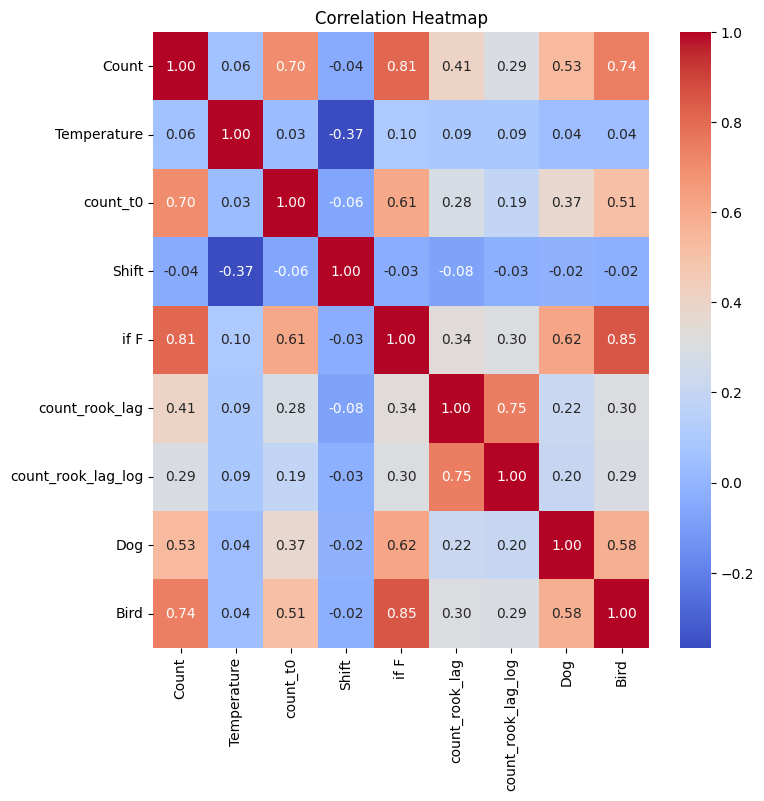

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(design_table[['Count', 'Temperature', 'count_t0', 'Shift', 'if F',
                           'count_rook_lag', 'count_rook_lag_log', 'Dog', 'Bird']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
selected_columns = ['Temperature',
       'Litter Amount', 'Dog', 'Bird', 'Other', 'Sunny', 'Cloudy', 'Rainy',
       'Busy', 'Calm', 'Moderate', 'count_t0',
       'if F', 'count_knn_lag', 'count_queen_lag',
       'count_rook_lag', 'count_rook_lag_log', 'count_queen_lag_log',
       'count_knn_lag_log']
X = design_table[selected_columns]
# 创建 MinMaxScaler 对象
scaler = MinMaxScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=selected_columns)
y = design_table['Count']

In [ ]:
np.random.seed(42)
train_indices = np.random.choice(X_scaled.index, size = int(len(X_scaled) * .75), replace = False)
test_indices = [i for i in X_scaled.index if i not in train_indices]
X_train = X_scaled.iloc[train_indices]
X_test = X_scaled.iloc[test_indices]
y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]

In [ ]:
X_train_pois = sm.add_constant(X_train[['if F', 'count_t0', 'count_knn_lag_log', 'Dog']])
model_pois = sm.GLM(y_train, X_train_pois,
                family = sm.families.Poisson())
results_pois = model_pois.fit()

# Print regression results
print(results_pois.summary())

In [ ]:
y_trained = results_pois.predict(sm.add_constant(X_train[['if F', 'count_t0', 'count_knn_lag_log', 'Dog']]))
print('The Training Mean Absolute Error of the Poisson model is:')
(sum((np.array(y_train - y_trained)**2)/len(y_train)))

In [ ]:
BPJB_test(results_pois, X_train_pois)

In [ ]:
y_pred_pois = results_pois.predict(sm.add_constant(X_test[['if F', 'count_t0', 'count_knn_lag_log', 'Dog']]))
print('The Testing R-squared of the Poisson model is:')
r2_score(y_test, y_pred_pois)

In [ ]:
print('The Testing Mean Absolute Error of the Poisson model is:')
(sum((np.array(y_test - y_pred_pois)**2)/len(y_test)))

The model has problems of heteroscedesticity and non-normal residuals. But its overfitting is arguably trivial.

To get better results, introduct the XGBoost model.

In [ ]:
X_train_xgb = X_train[['if F', 'count_t0', 'count_knn_lag_log', 'Bird', 'Dog', 'Litter Amount']]
X_test_xgb = X_test[['if F', 'count_t0', 'count_knn_lag_log', 'Bird', 'Dog', 'Litter Amount']]

# Fit the Poisson regression model with spatial weights
model_xgb = xgb.XGBRegressor(objective = "reg:squarederror", random_state = 42)
model_xgb.fit(X_train_xgb, y_train)

# 进行预测
y_train_pred = model_xgb.predict(X_train_xgb)
y_test_pred = model_xgb.predict(X_test_xgb)

# 输出均方误差
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on training set: {mse_train}")
print(f"Mean Squared Error on training set: {mse_test}")

from sklearn.metrics import r2_score

# 计算R平方
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("R^2 score on training dataset: " , r2_train)
print("R^2 score on test dataset: " , r2_test)

The model is fitted pretty well though the testing scores and R-squared are also slightly underperformed than the training.

##XGBoost Visualization

In [ ]:
from xgboost import plot_importance

# 假设 model 是你训练好的 XGBoost 模型
plot_importance(model_xgb)

In [ ]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(model_xgb, num_trees=0, rankdir='LR')
plt.show()

Prune the model.

In [ ]:
params = {
    'gamma': 0.1,
    'alpha': 0.2,
    'lambda': 0.2,
    # Other parameters
}
xgb_pruned = xgb.XGBRegressor(**params, objective = "reg:squarederror", random_state = 42)

In [ ]:
xgb_pruned.fit(X_train_xgb, y_train)

# 进行预测
y_trn_pred_pruned = xgb_pruned.predict(X_train_xgb)
y_tst_pred_pruned = xgb_pruned.predict(X_test_xgb)

# 输出均方误差
mse_train_pruned = mean_squared_error(y_train, y_trn_pred_pruned)
mse_test_pruned = mean_squared_error(y_test, y_tst_pred_pruned)
print(f"Mean Squared Error on training set: {mse_train_pruned}")
print(f"Mean Squared Error on training set: {mse_test_pruned}")

from sklearn.metrics import r2_score

# 计算R平方
r2_train_pruned = r2_score(y_train, y_trn_pred_pruned)
r2_test_pruned = r2_score(y_test, y_tst_pred_pruned)
print("R^2 score on training dataset: " , r2_train_pruned)
print("R^2 score on test dataset: " , r2_test_pruned)